# Projection Experiment

I’m doing some thresholding here, and since I’m lazy, I’ll be using scikit-image’s thresholding functions

## imports and misc

In [174]:
import logging
import os
import sys
import warnings
import itertools as it
from time import perf_counter
def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)
    
#You don’t need those lines if you installed the packages
append_path("/home/tristan/research/ot_markov_distances/")
append_path("/home/tristan/research/tb_ml/")
append_path("/home/tristan/research/FGW/lib")

logging.basicConfig(level=logging.INFO, force=True)

In [175]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange


In [210]:
from skimage.filters import threshold_otsu, threshold_yen

In [176]:
from ot_markov_distances import wl_reg_infty
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov
from utils.modules import ParametricMarkovMatrixWithMatchings, ParametricMarkovMatrix, ParametricMarkovMatrixWithLabels
from utils.data_generation import circle_graph, FGW_build_noisy_circular_graph, add_er_noise

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
logging.basicConfig(level=logging.WARNING, force=True)

## Data

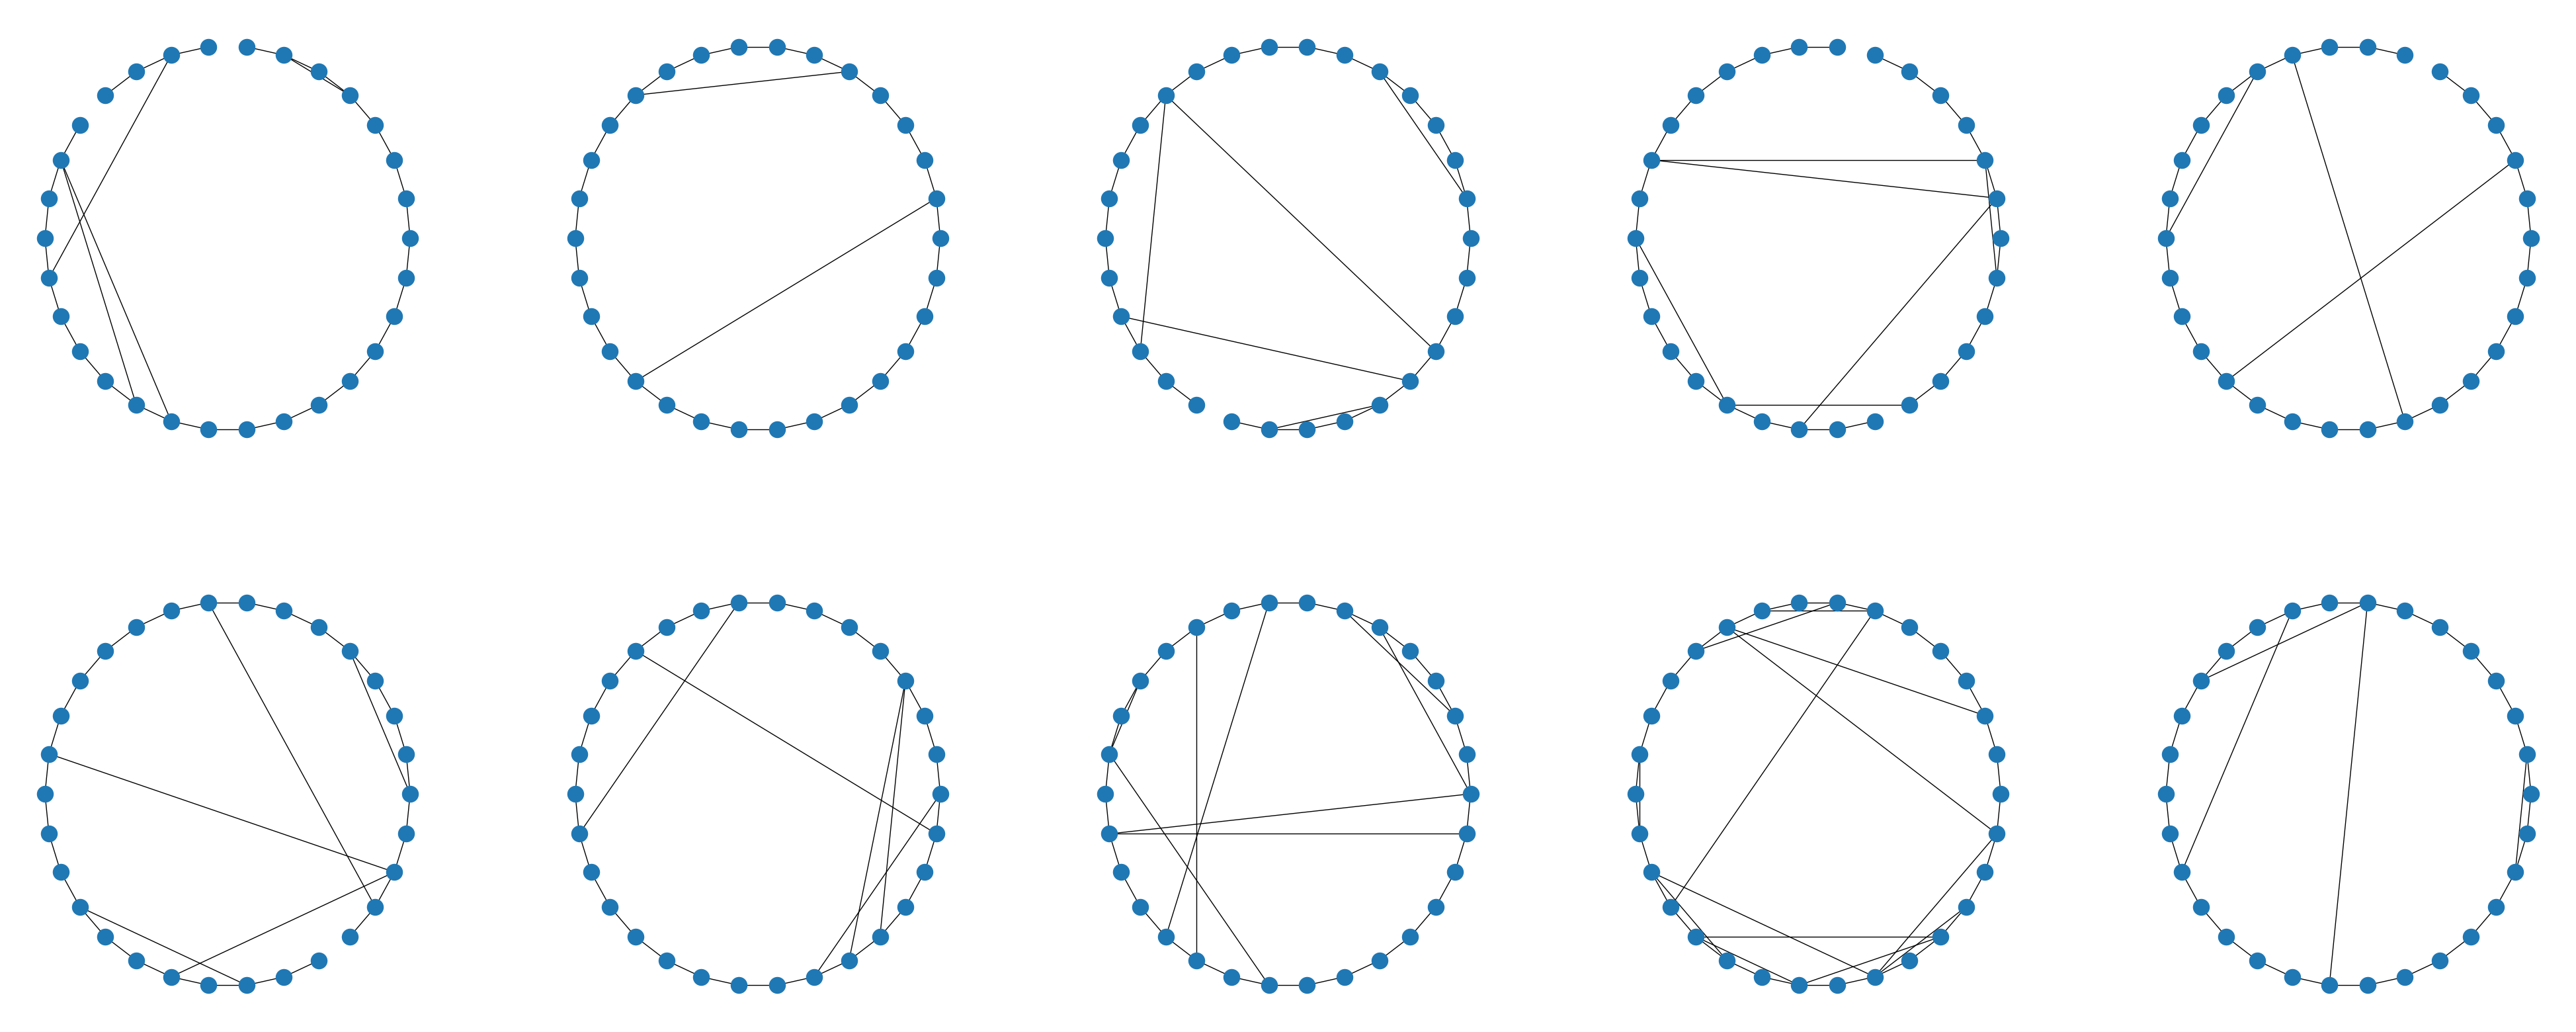

In [234]:
data_type = "ER_noise_circles"
target_size = 30
n_targets = 10

def get_data(target_size, n_targets, data_type, er_p=.01):
    target_sizes= [target_size] * n_targets
    match data_type:
        case "sampled_circles":
            target_graphs = [circle_graph(size, kind="distance") for size in target_sizes]
            original_positions = np.asarray(list(nx.get_node_attributes(target_graphs[0], "pos").values()))
            target_labels = None
        case "ER_noise_circles":
            target_graphs = [add_er_noise(FGW_build_noisy_circular_graph(size, sigma=0), p=er_p) for size in target_sizes]
            target_labels = [get_label_matrix(g) for g in target_graphs]
            original_positions = None
    target_matrices = [weighted_transition_matrix(g, q=.1) for g in target_graphs]
    return target_graphs, original_positions, target_labels, target_matrices

target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_targets, data_type)
        
_, axes = plt.subplots(n_targets // 5, 5 , figsize=(50, 10 * (n_targets // 5) ))
for G, ax in zip(target_graphs, axes.flat):
    nx.draw(G, pos=nx.get_node_attributes(G, "pos"), ax=ax)


## Optimization loop

In [179]:
%%script true
def opt_loop(target_matrices, 
             n_steps=300, projection_size=5, 
             run_name="barycenter", 
            device = torch.device("cuda:3"), 
             lr=1e-2, 
             weight_decay=0,
             heat=1.,
             matching_heat=1.,
             wl_parameters = dict(delta=.5, sinkhorn_reg=.1, sinkhorn_iter=10, sinkhorn_iter_scheduler="cosine")
            ):
    
    target_sizes = [matrix.shape[0] for matrix in target_matrices]
    target_matrices = [matrix.to(device) for matrix in target_matrices]
    projection = ParametricMarkovMatrixWithMatchings(projection_size, 
                                                     *target_sizes, 
                                                     heat=heat,
                                                    matching_heat=matching_heat).to(device)

    target_measures = [
        torch.ones(size, device=device, requires_grad=False) / size
        for size in target_sizes]
    projection_measure = torch.ones(projection_size, device=device, requires_grad=False) / projection_size


    optim = torch.optim.Adam(projection.parameters(), lr=lr, weight_decay=weight_decay)

    writer = SummaryWriter(f"{os.environ['HOME']}/tensorboard/{run_name}")
    parameter_values = []
    losses = []

    for step in trange(n_steps):
        optim.zero_grad()

        M, *Ds = projection()
        loss = 0
        for target_m, D, target_measure in zip(target_matrices, Ds,  target_measures):
            loss = loss + wl_reg_infty(M[None, ...], 
                                target_m[None, ...], 
                                D[None, ...], 
                                muX=projection_measure[None, ...],
                                muY=target_measure[None, ...],
                                **wl_parameters).square()
        loss.backward()
        optim.step()


        writer.add_scalar("loss", loss, step) 
        losses.append(loss.item())
        with torch.no_grad():
            markov, *matchings = projection.get()
            parameter_values.append(
                (markov.numpy(force=True), 
                 *(matching.detach().cpu() for matching in matchings)
                )
            )
            
    return projection, parameter_values, losses

projection, parameter_values, losses = opt_loop(target_matrices, projection_size=5,
    n_steps=300,
    heat=1/30,
    run_name=f"barycenter5 - {(run_number:=vars().get('run_number', 0)+1)}")
projection.draw(original_positions)

In [259]:
def opt_loop_batched(target_matrices, 
             n_steps=300, projection_size=5, 
             run_name="barycenter", 
            device = torch.device("cuda:3"), 
             lr=1e-2, 
             weight_decay=0,
             heat=1.,
             matching_heat=1.,
             wl_parameters = dict(delta=.3, sinkhorn_reg=.01, sinkhorn_iter=10, sinkhorn_iter_scheduler="cosine"),
             labels = None
            ):
    
    n_targets = len(target_matrices)
    target_sizes = [matrix.shape[0] for matrix in target_matrices]
    target_matrices = [matrix.to(device) for matrix in target_matrices]
    target_matrices_batched = torch.stack(target_matrices, dim=0)
    
    if labels is None:
        projection = ParametricMarkovMatrixWithMatchings(projection_size, 
                                                         *target_sizes, 
                                                         heat=heat,
                                                        matching_heat=matching_heat).to(device)
    else:
        projection = ParametricMarkovMatrixWithLabels(projection_size, *labels, heat=heat).to(device)
                                        

    target_measures = [
        torch.ones(size, device=device, requires_grad=False) / size
        for size in target_sizes]
    target_measures_batched = torch.stack(target_measures, dim=0)
    
    projection_measure = torch.ones((n_targets, projection_size), device=device, requires_grad=False) / projection_size


    optim = torch.optim.Adam(projection.parameters(), lr=lr, weight_decay=weight_decay)

    writer = SummaryWriter(f"{os.environ['HOME']}/tensorboard/{run_name}")
    parameter_values = []
    losses = []

    for step in trange(n_steps):
        optim.zero_grad()

        M, *Ds = projection()
        batched_Ds = torch.stack(Ds, dim=0)
        batched_M = M.expand(n_targets, -1, -1)
        
        loss = wl_reg_infty(batched_M, 
                            target_matrices_batched, 
                            batched_Ds, 
                            muX=projection_measure,
                            muY=target_measures_batched,
                            **wl_parameters).square().sum(0)
        loss.backward()
        optim.step()


        writer.add_scalar("loss", loss, step) 
        losses.append(loss.item())
        with torch.no_grad():
            markov, *matchings = projection.get()
            parameter_values.append(
                (markov.numpy(force=True), 
                 *(matching.detach().cpu() for matching in matchings)
                )
            )
            
    return projection, parameter_values, losses


## Tests

In [169]:
projection_size = 20

projection, parameter_values, losses = opt_loop_batched(
    target_matrices, 
    projection_size=projection_size,
    n_steps=1500,
    heat=1,
    lr=5e-3,
    weight_decay=1e-6,
    run_name=f"{data_type} - barycenter{projection_size} - {(run_number:=vars().get('run_number', 0)+1)}",
    labels=target_labels)

projection.draw(original_positions)

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

<AxesSubplot:>

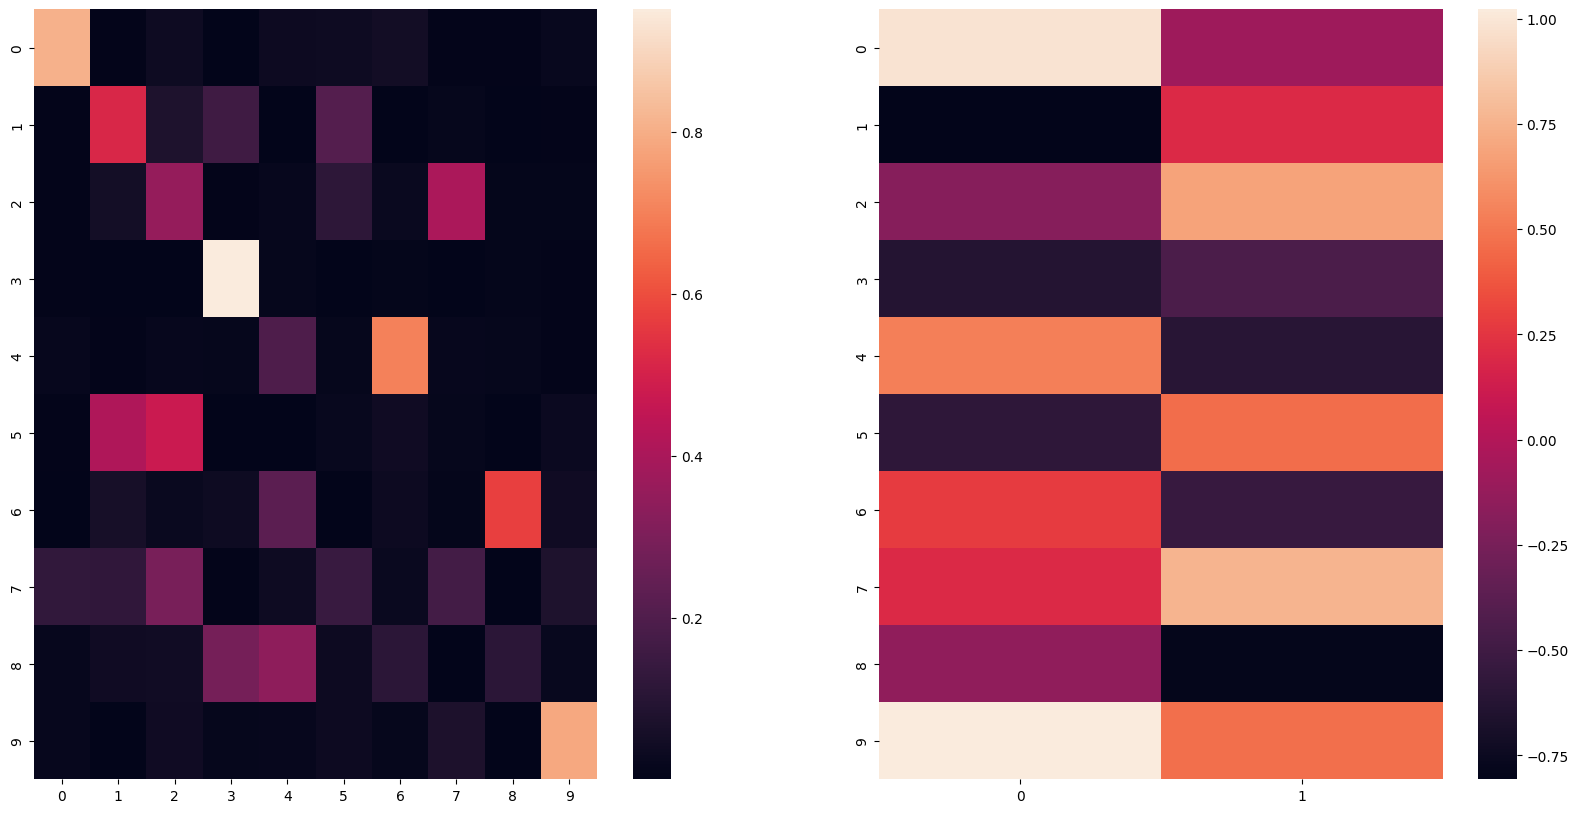

In [108]:
last_markov, last_matching, *_ = parameter_values[-1]
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(last_markov, ax=axes[0])
sns.heatmap(last_matching, ax=axes[1])

### Barycenter size 10

  0%|          | 0/500 [00:00<?, ?it/s]

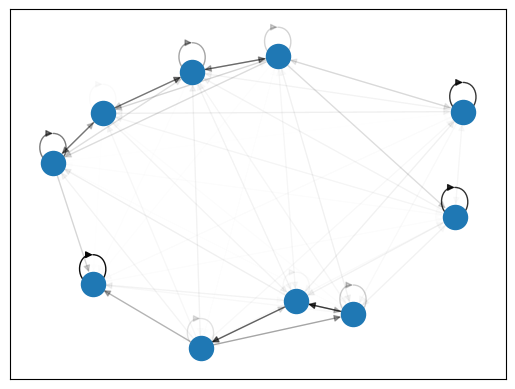

In [107]:
projection, parameter_values, losses = opt_loop_batched(target_matrices, projection_size=10,
    n_steps=500,
    heat=1/10,
    lr=5e-3,
    weight_decay=1e-6,
    run_name=f"data_type - barycenter10 - {(run_number10:=vars().get('run_number10', 0)+1)}",
    labels=target_labels
                                                       ) #funny how I didn’t even write this line with making the ugliest possible code in mind
#Even though it’s got 3 "arcane" features of python in a single expression: f-strings (lawful good), vars() (cahotic neutral), and := (cahotic evil)


projection.draw(original_positions)

<AxesSubplot:>

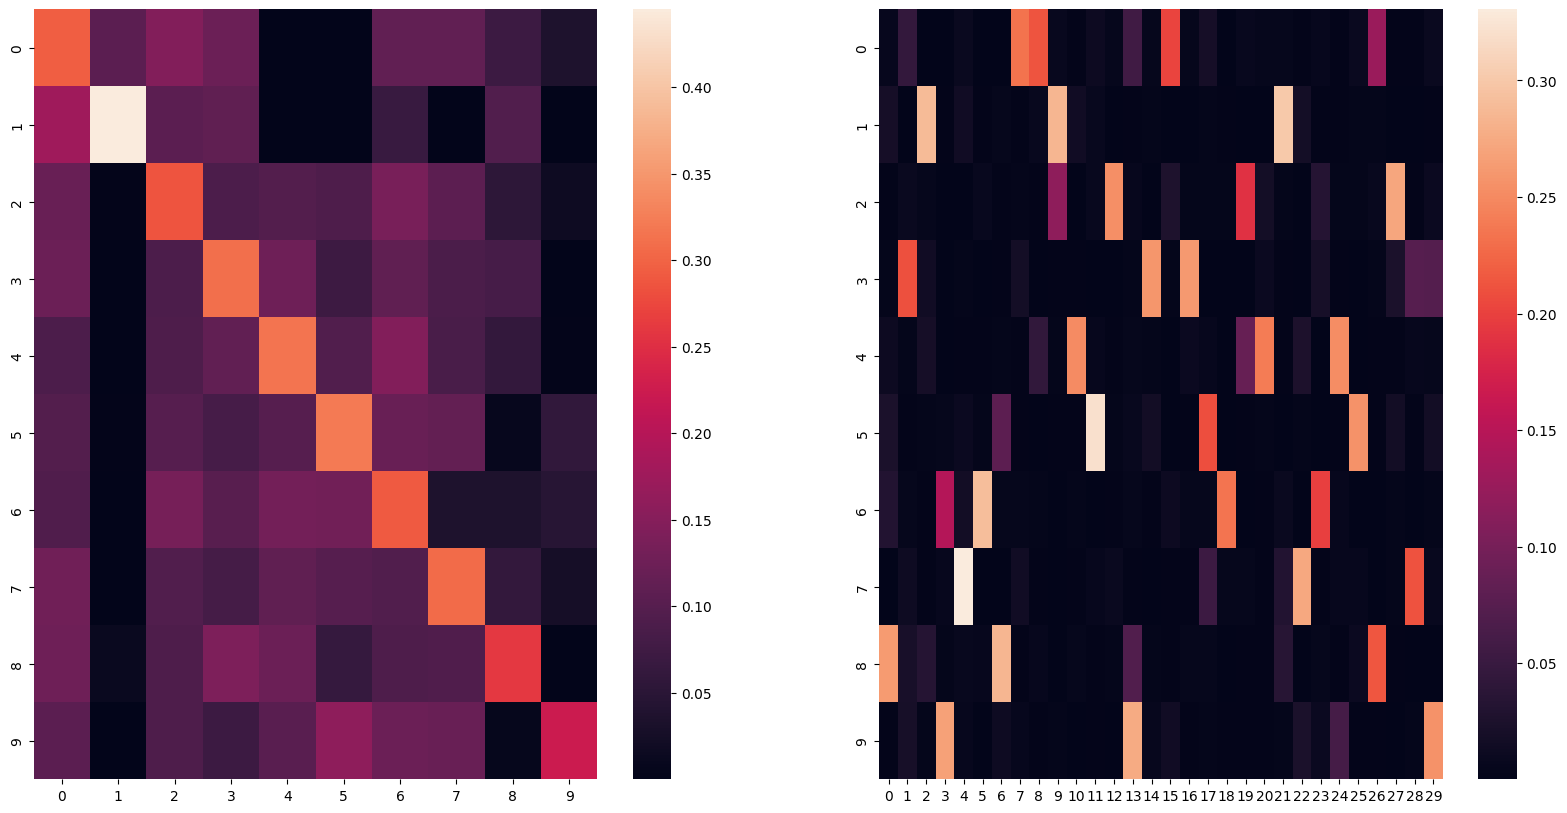

In [91]:
last_markov, last_matching, *_ = parameter_values[-1]
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(last_markov, ax=axes[0])
sns.heatmap(last_matching, ax=axes[1])

## Grid search

In [168]:
%store -r projection_grid
projection_size = target_size = 20
noise_values = [0, .001, .005, .01, .1]
n_target_parameters = [1, 5, 10, 20, 30, 50]

def grid_init(*args):
    match args:
        case []:
            return None
        case [n0, *tail]:
            return [grid_init(*tail) for _ in range(n0)]
if "projection_grid" not in vars():
    projection_grid = grid_init(len(noise_values), len(n_target_parameters))


Stored 'projection_grid_old' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


  0%|          | 0/5000 [00:00<?, ?it/s]

Stored 'projection_grid' (list)


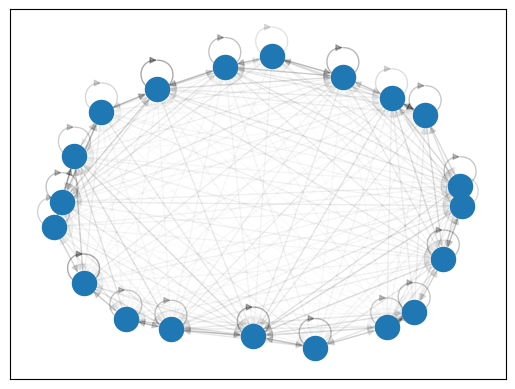

In [192]:
for (noise_index, noise), (n_target_index, n_target) in \
    it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_target, data_type,
                                                                   er_p=noise)
    if projection_grid[noise_index][n_target_index] is not None:
        continue
    projection, parameter_values, losses = opt_loop_batched(
        target_matrices, 
        projection_size=projection_size,
        n_steps=5000,
        heat=5,
        lr=5e-3,
        weight_decay=1e-6,
        run_name=f"{data_type} - barycenter{projection_size} - {(run_number:=vars().get('run_number', 0)+1)}",
        labels=target_labels
    )
    
    projection_grid[noise_index][n_target_index] = projection.cpu()
    
    %store projection_grid

projection.draw(original_positions)

[autoreload of ot_markov_distances.sinkhorn failed: Traceback (most recent call last):
  File "/home/tristan/miniconda3/envs/default/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/tristan/miniconda3/envs/default/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/home/tristan/miniconda3/envs/default/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/tristan/miniconda3/envs/default/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 333, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/tristan/miniconda3/envs/default/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/tristan/miniconda3/envs/default/lib/python3.10/site-packages/IPyth

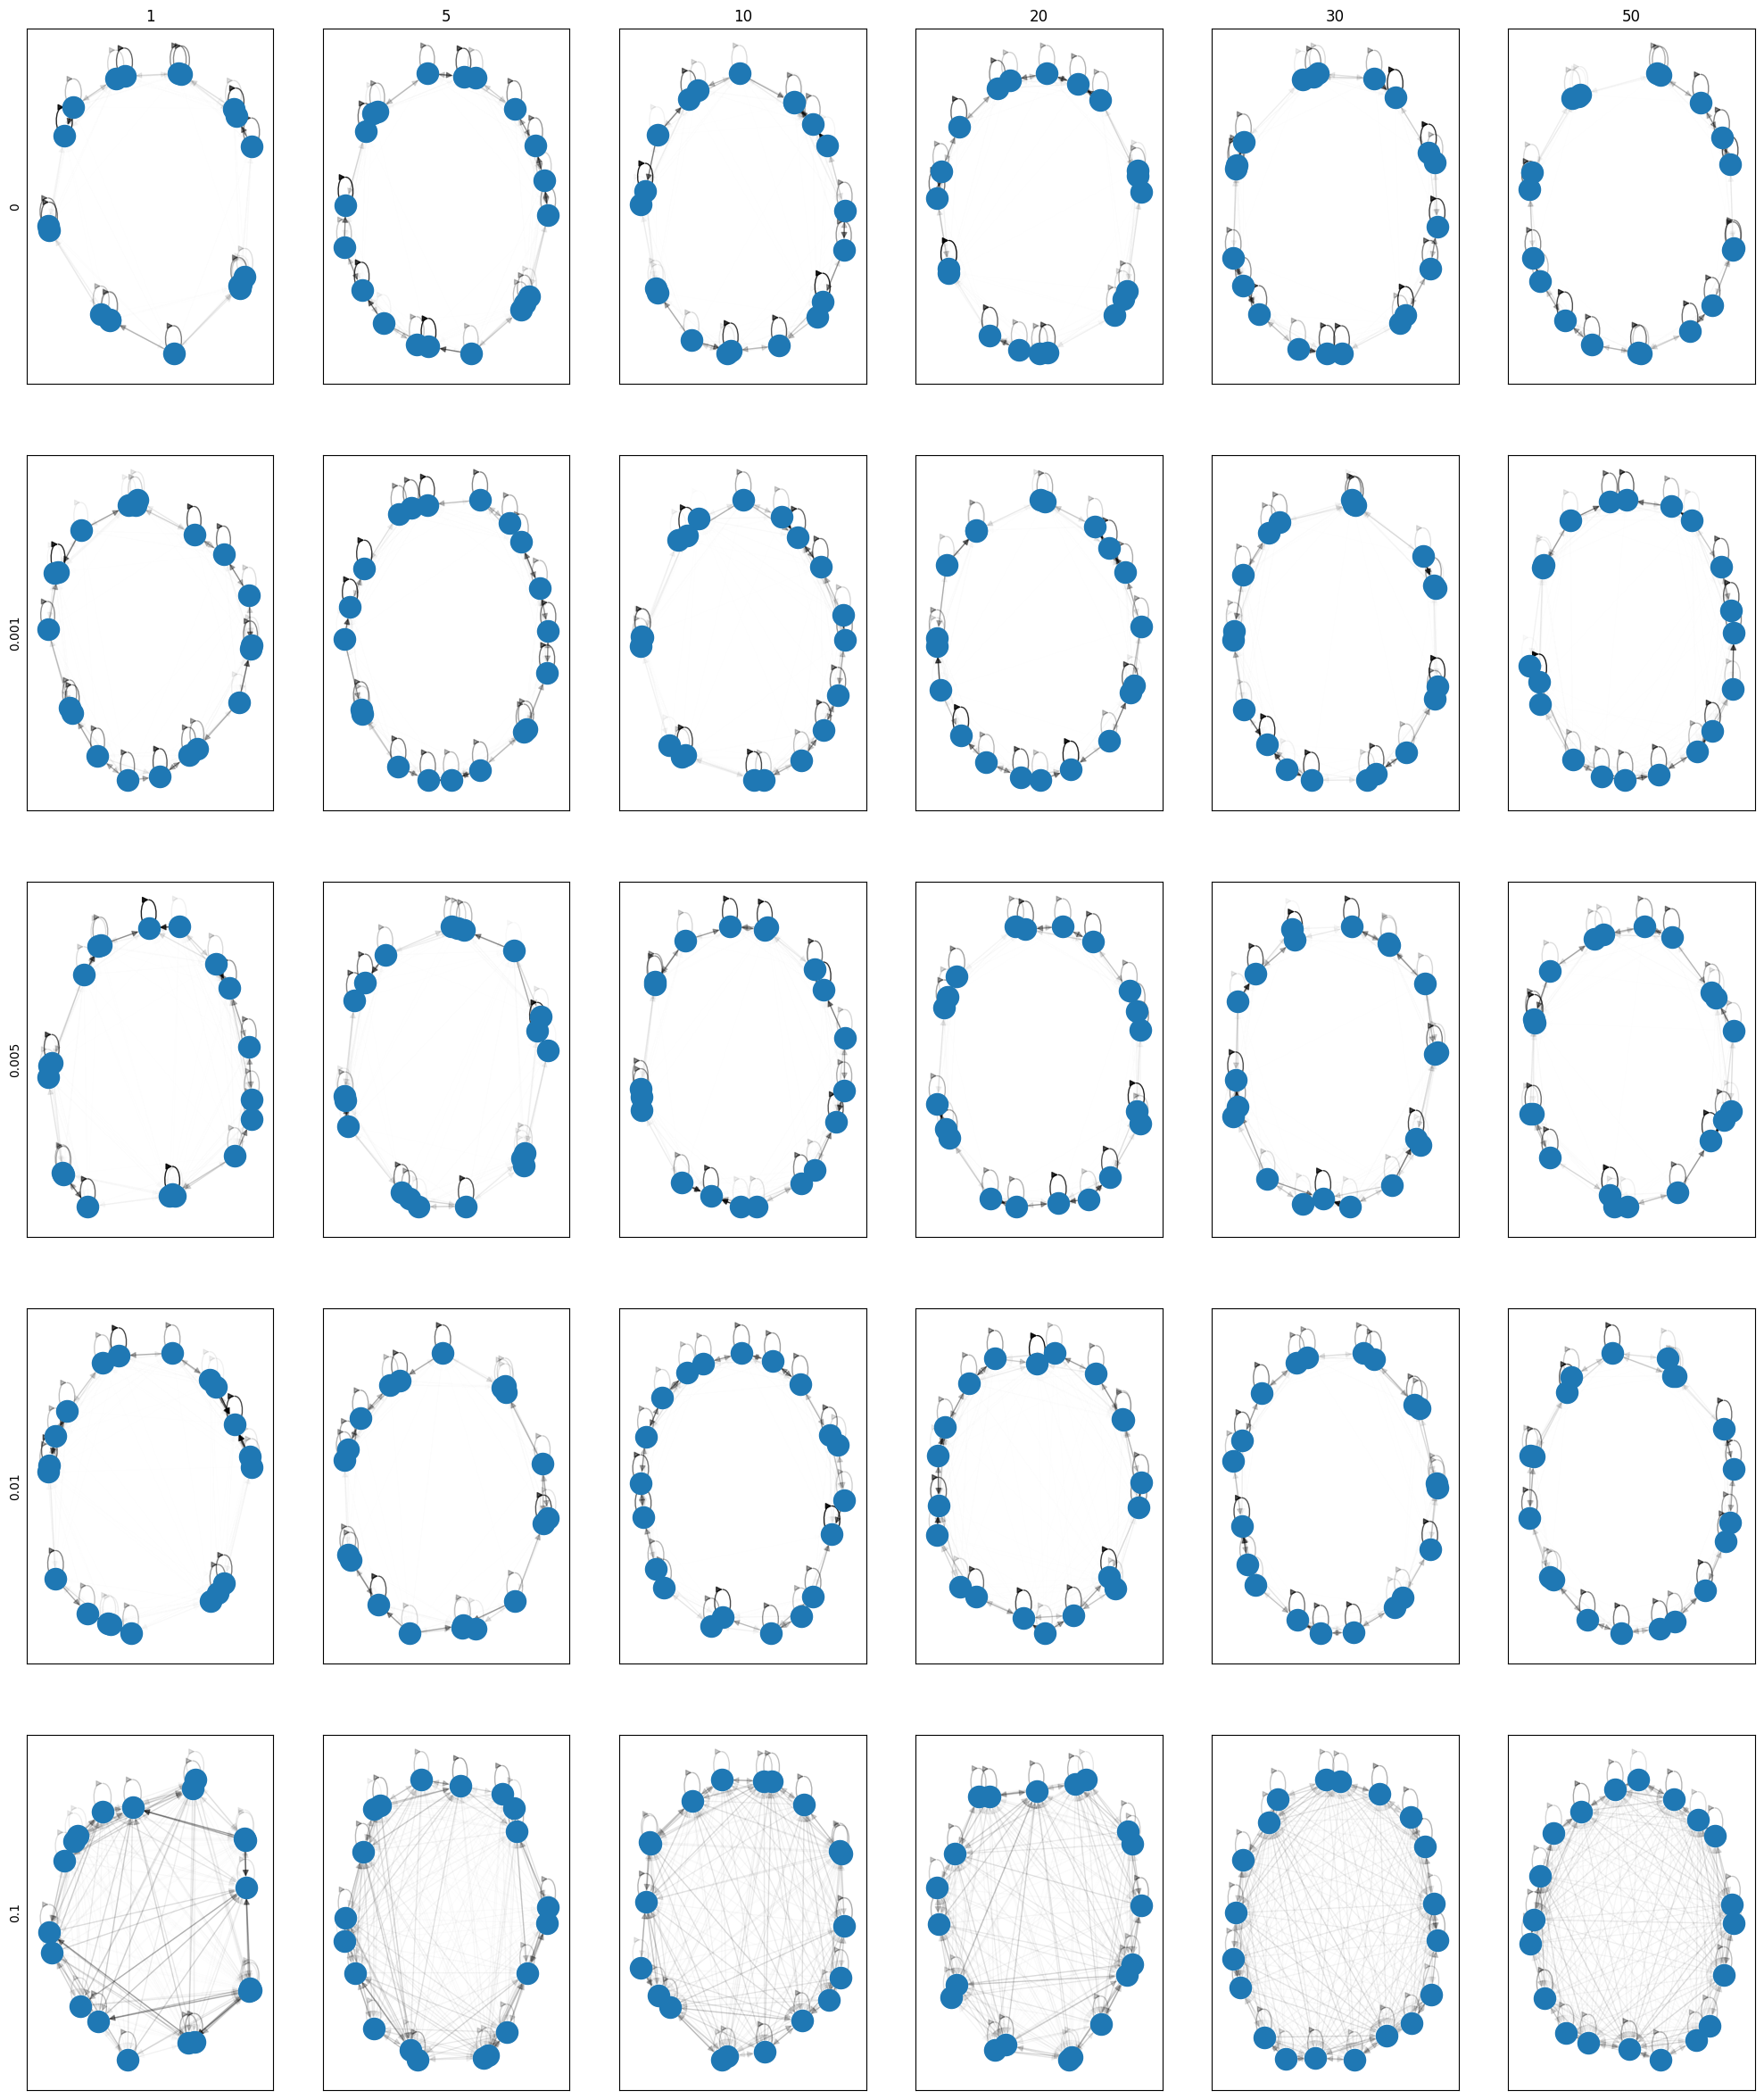

In [193]:
_, axes = plt.subplots(len(noise_values), len(n_target_parameters), figsize =(len(noise_values)*5, len(n_target_parameters)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    projection_grid[i][j].draw(ax=axes[i,j])
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


In [255]:
def my_threshold(M):
    median = np.median(M)
    #print(median)
    return 3 * median # why hard when it could be easy

def markov_threshold(M, method=my_threshold):
    threshold = method(M)
    G = nx.from_numpy_array( M> threshold, create_using=nx.DiGraph)
    return G

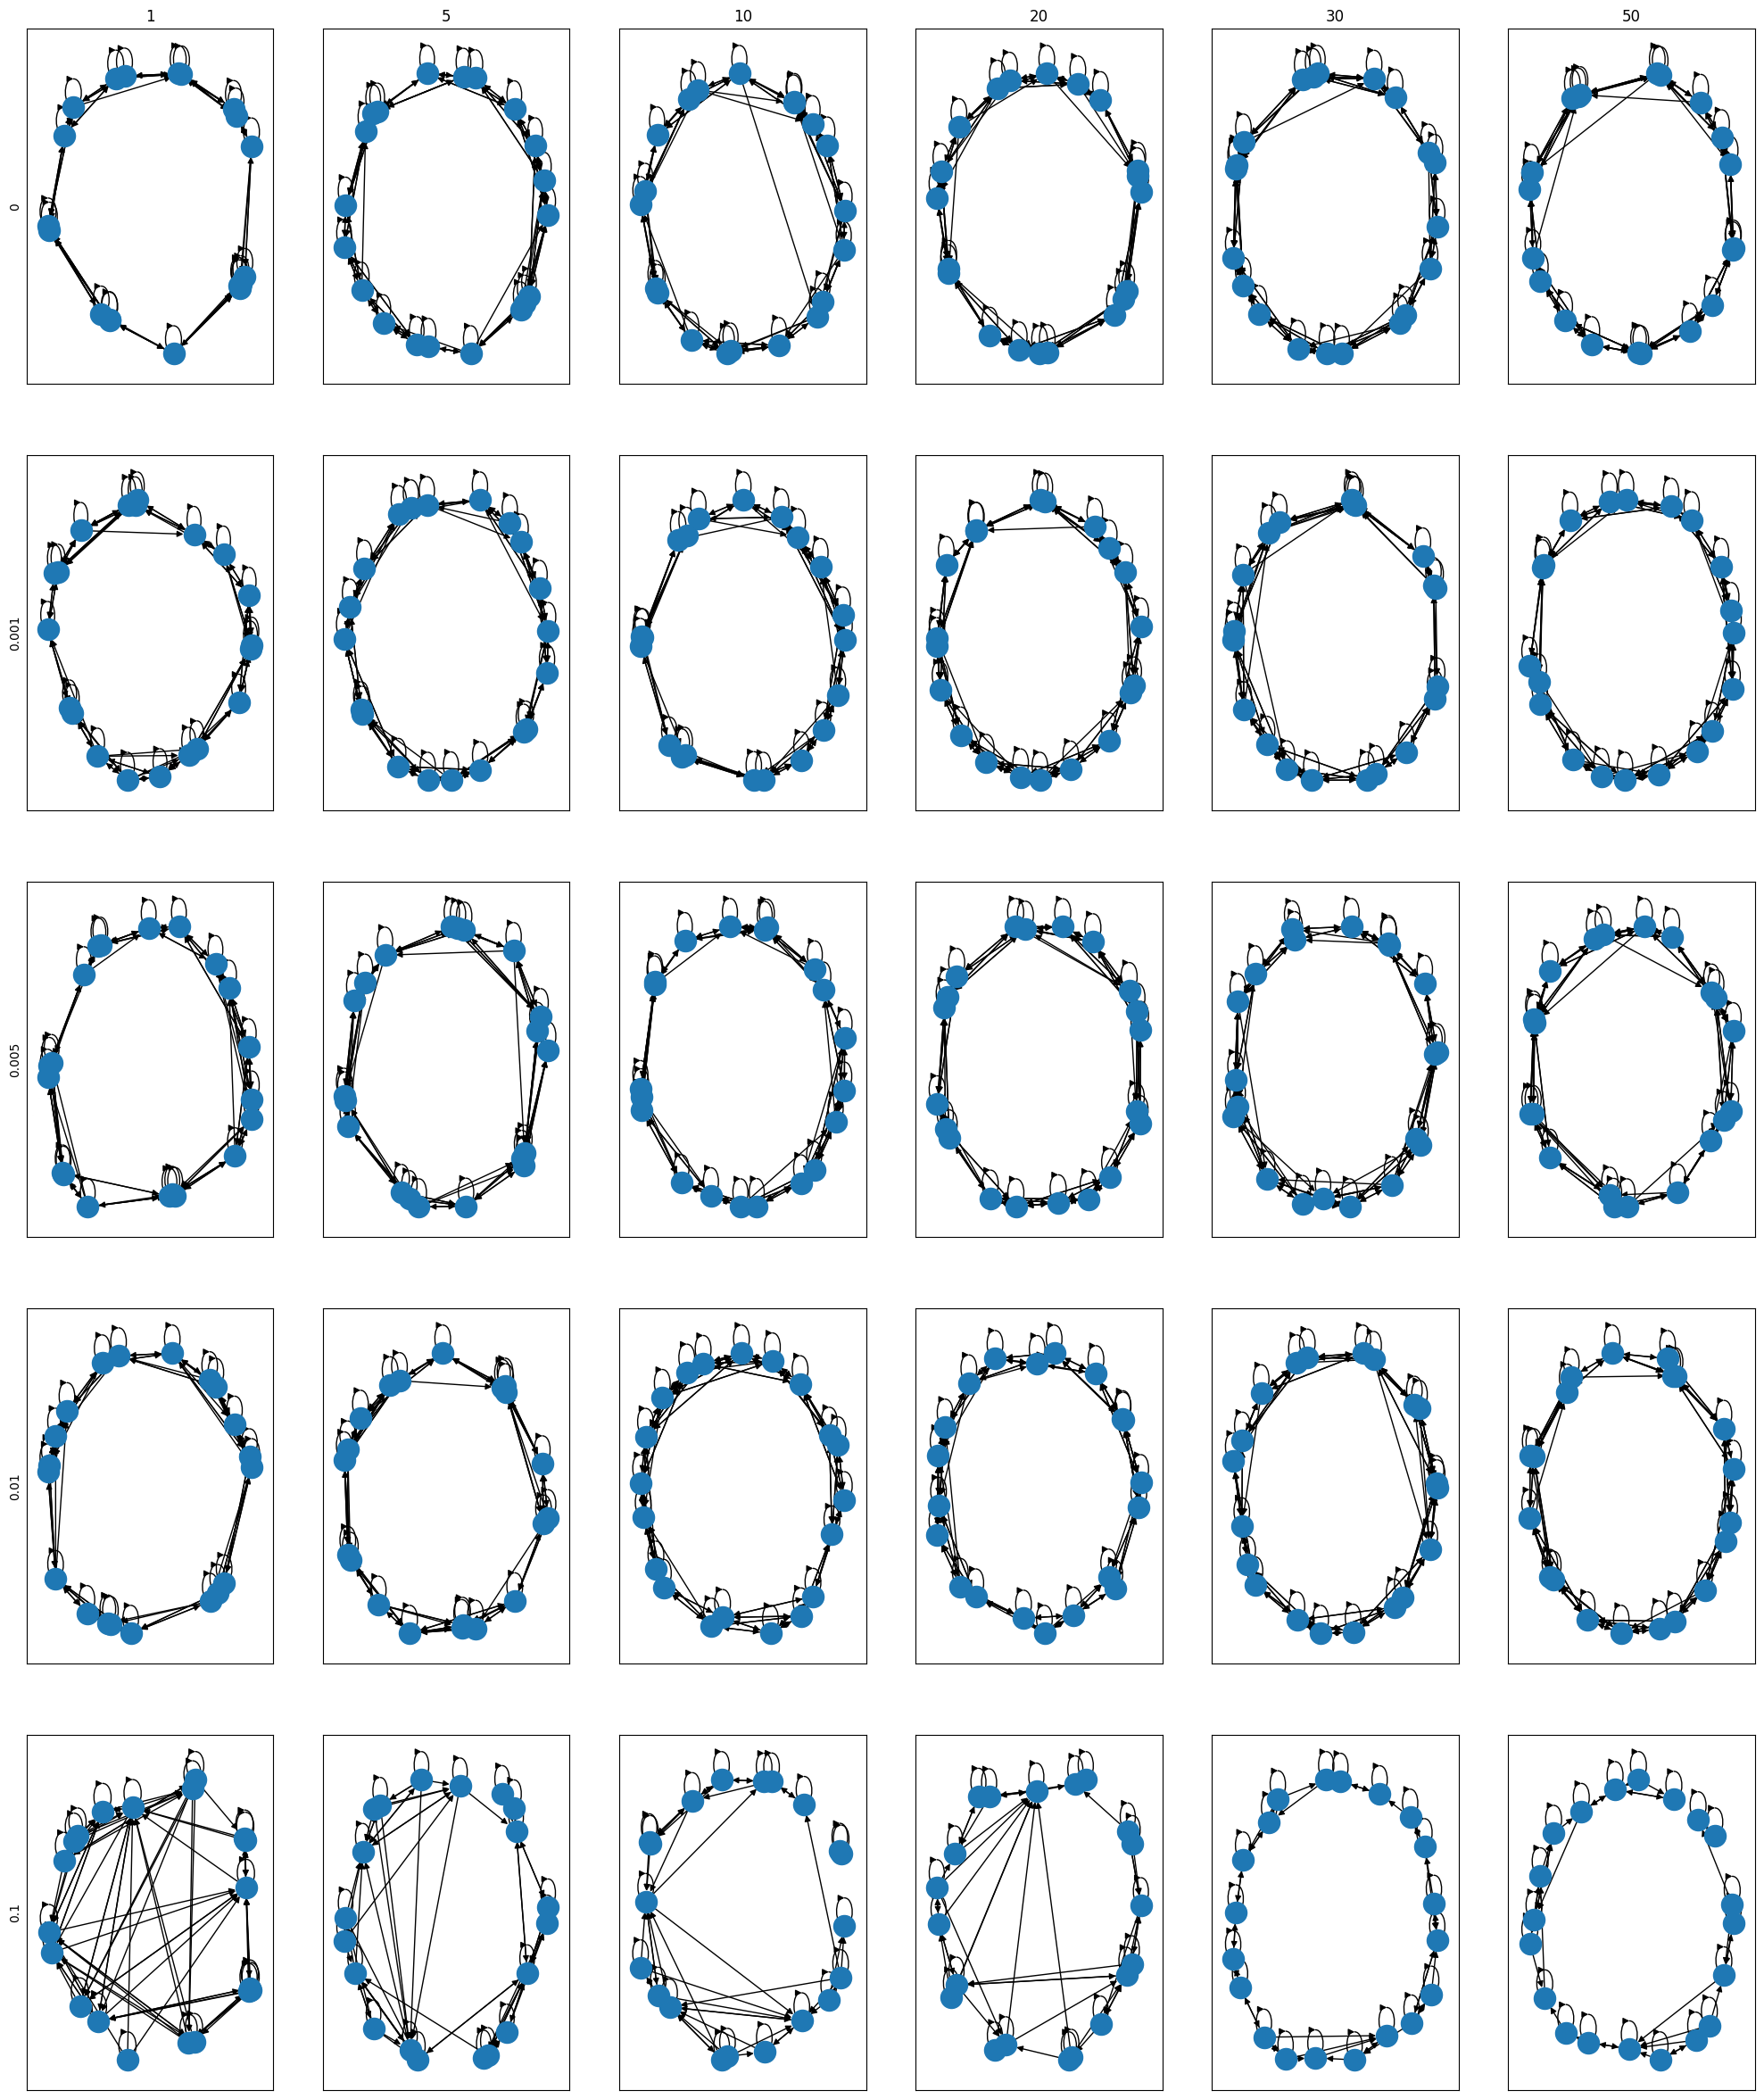

In [256]:
_, axes = plt.subplots(len(noise_values), len(n_target_parameters), figsize =(len(noise_values)*5, len(n_target_parameters)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    markov, labels = projection_grid[i][j].get()
    G = markov_threshold(markov.numpy(force=True))
    pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
    nx.draw(G, pos, ax=axes[i, j])
    axes[i, j].set_axis_on()
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


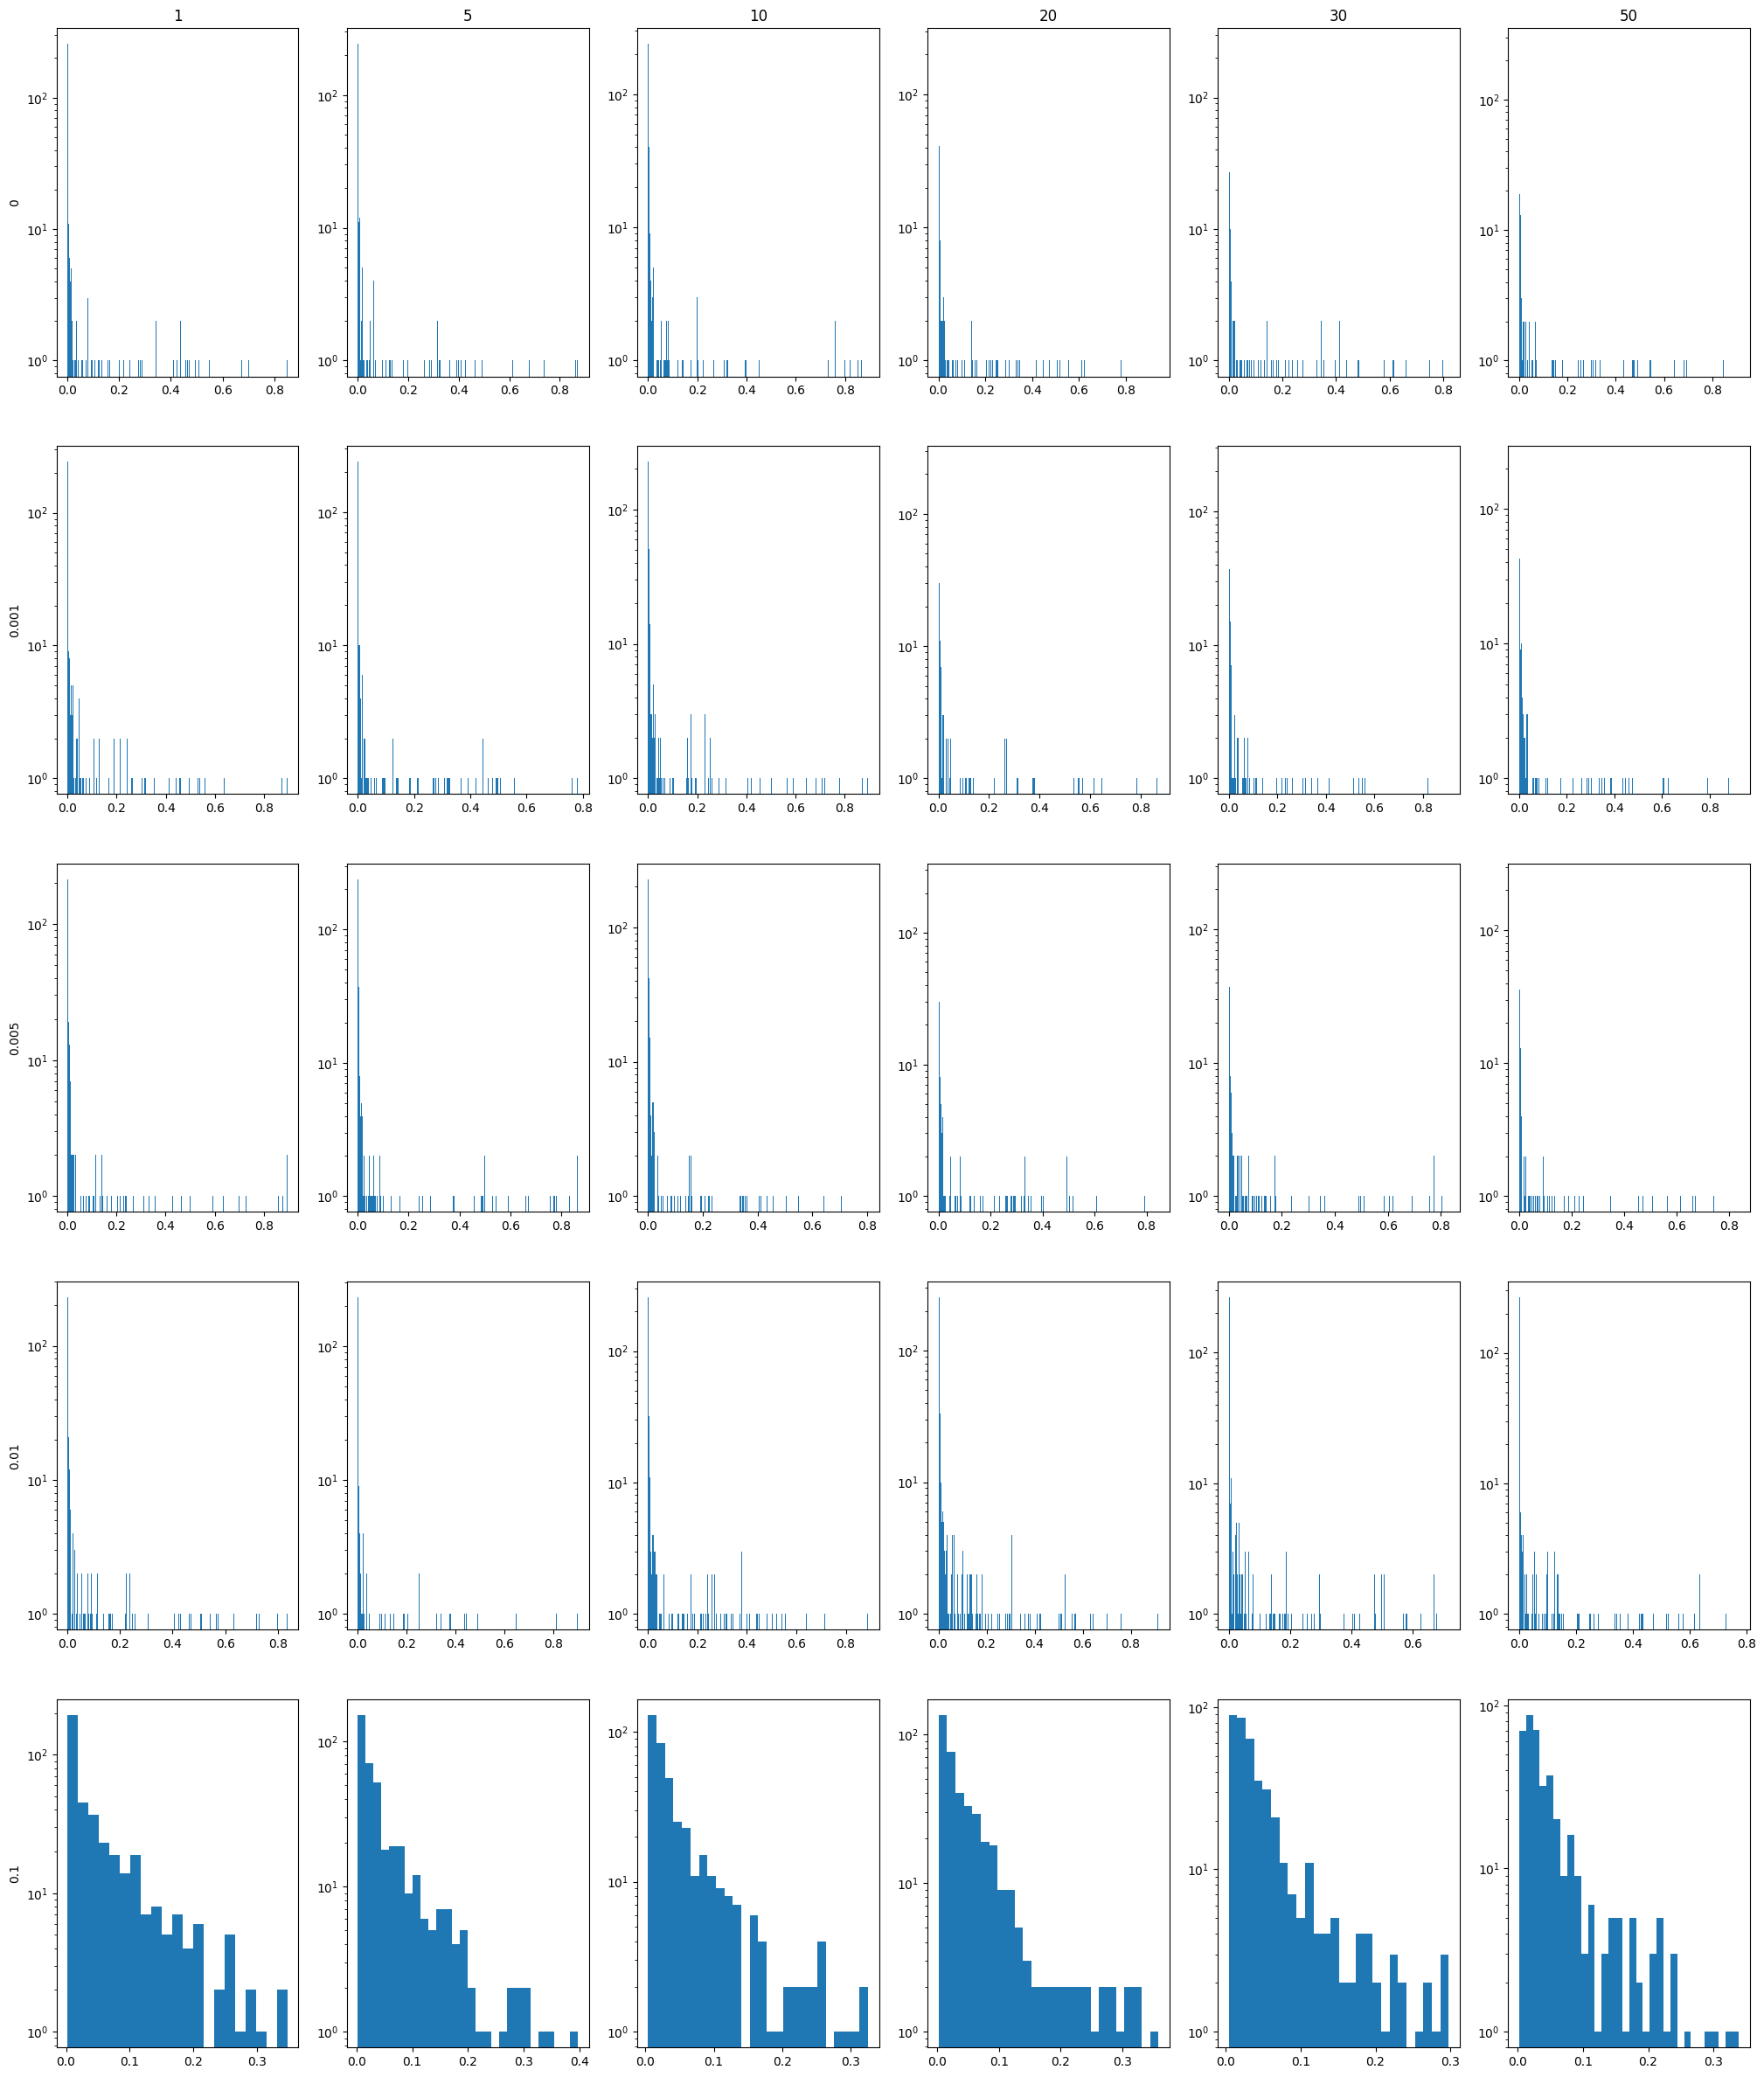

In [233]:
_, axes = plt.subplots(len(noise_values), len(n_target_parameters), figsize =(len(noise_values)*5, len(n_target_parameters)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    markov, labels = projection_grid[i][j].get()
    G = markov_threshold(markov.numpy(force=True))
    pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
    plt.sca(axes[i, j])
    plt.hist(markov.numpy(force=True).flatten(), bins="auto")
    plt.yscale("log")
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


  0%|          | 0/5000 [00:00<?, ?it/s]

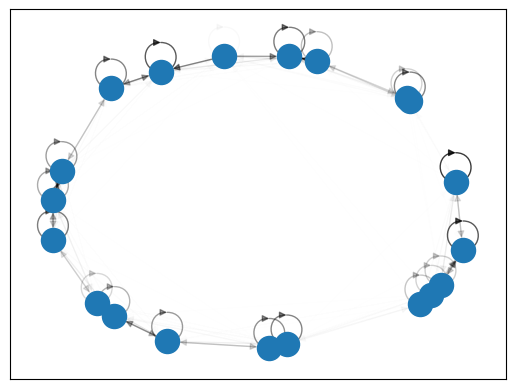

In [189]:
projection, parameter_values, losses = opt_loop_batched(
    target_matrices, 
    projection_size=projection_size,
    n_steps=5000,
    heat=5,
    lr=5e-3,
    weight_decay=1e-6,
    run_name=f"{data_type} - barycenter{projection_size} - {(run_number:=vars().get('run_number', 0)+1)}",
    labels=target_labels
)
projection.draw()

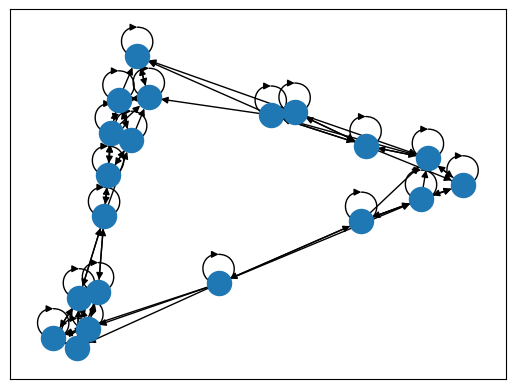

In [188]:
draw_markov(M >= .01)

## Grid search 2

In [261]:
del projection_grid2
projection_size = target_size = 20
noise_values2 = [.01, .05 ,.1, .2, .3]
n_target_parameters2 = [5, 10, 25, 50]

def grid_init(*args):
    match args:
        case []:
            return None
        case [n0, *tail]:
            return [grid_init(*tail) for _ in range(n0)]
if "projection_grid2" not in vars():
    projection_grid2 = grid_init(len(noise_values2), len(n_target_parameters2))


  0%|          | 0/5000 [00:00<?, ?it/s]

/home/tristan/research/ot_markov_distances/ot_markov_distances/discounted_wl.py:85: UserWarning: regularized WL did not converge
  warnings.warn("regularized WL did not converge")


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

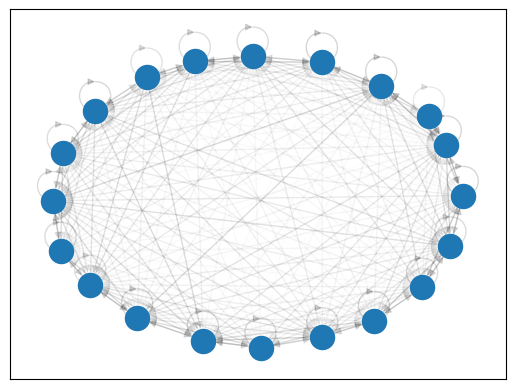

In [262]:
for (noise_index, noise), (n_target_index, n_target) in \
    it.product(enumerate(noise_values2), enumerate(n_target_parameters2)):
    target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_target, data_type,
                                                                   er_p=noise)
    if projection_grid2[noise_index][n_target_index] is not None:
        continue
    projection, parameter_values, losses = opt_loop_batched(
        target_matrices, 
        projection_size=projection_size,
        n_steps=5000,
        heat=5,
        lr=5e-3,
        weight_decay=1e-6,
        run_name=f"{data_type} - barycenter{projection_size} - {(run_number:=vars().get('run_number', 0)+1)}",
        labels=target_labels
    )
    
    projection_grid2[noise_index][n_target_index] = projection.cpu()
    
    #%store projection_grid2

projection.draw(original_positions)

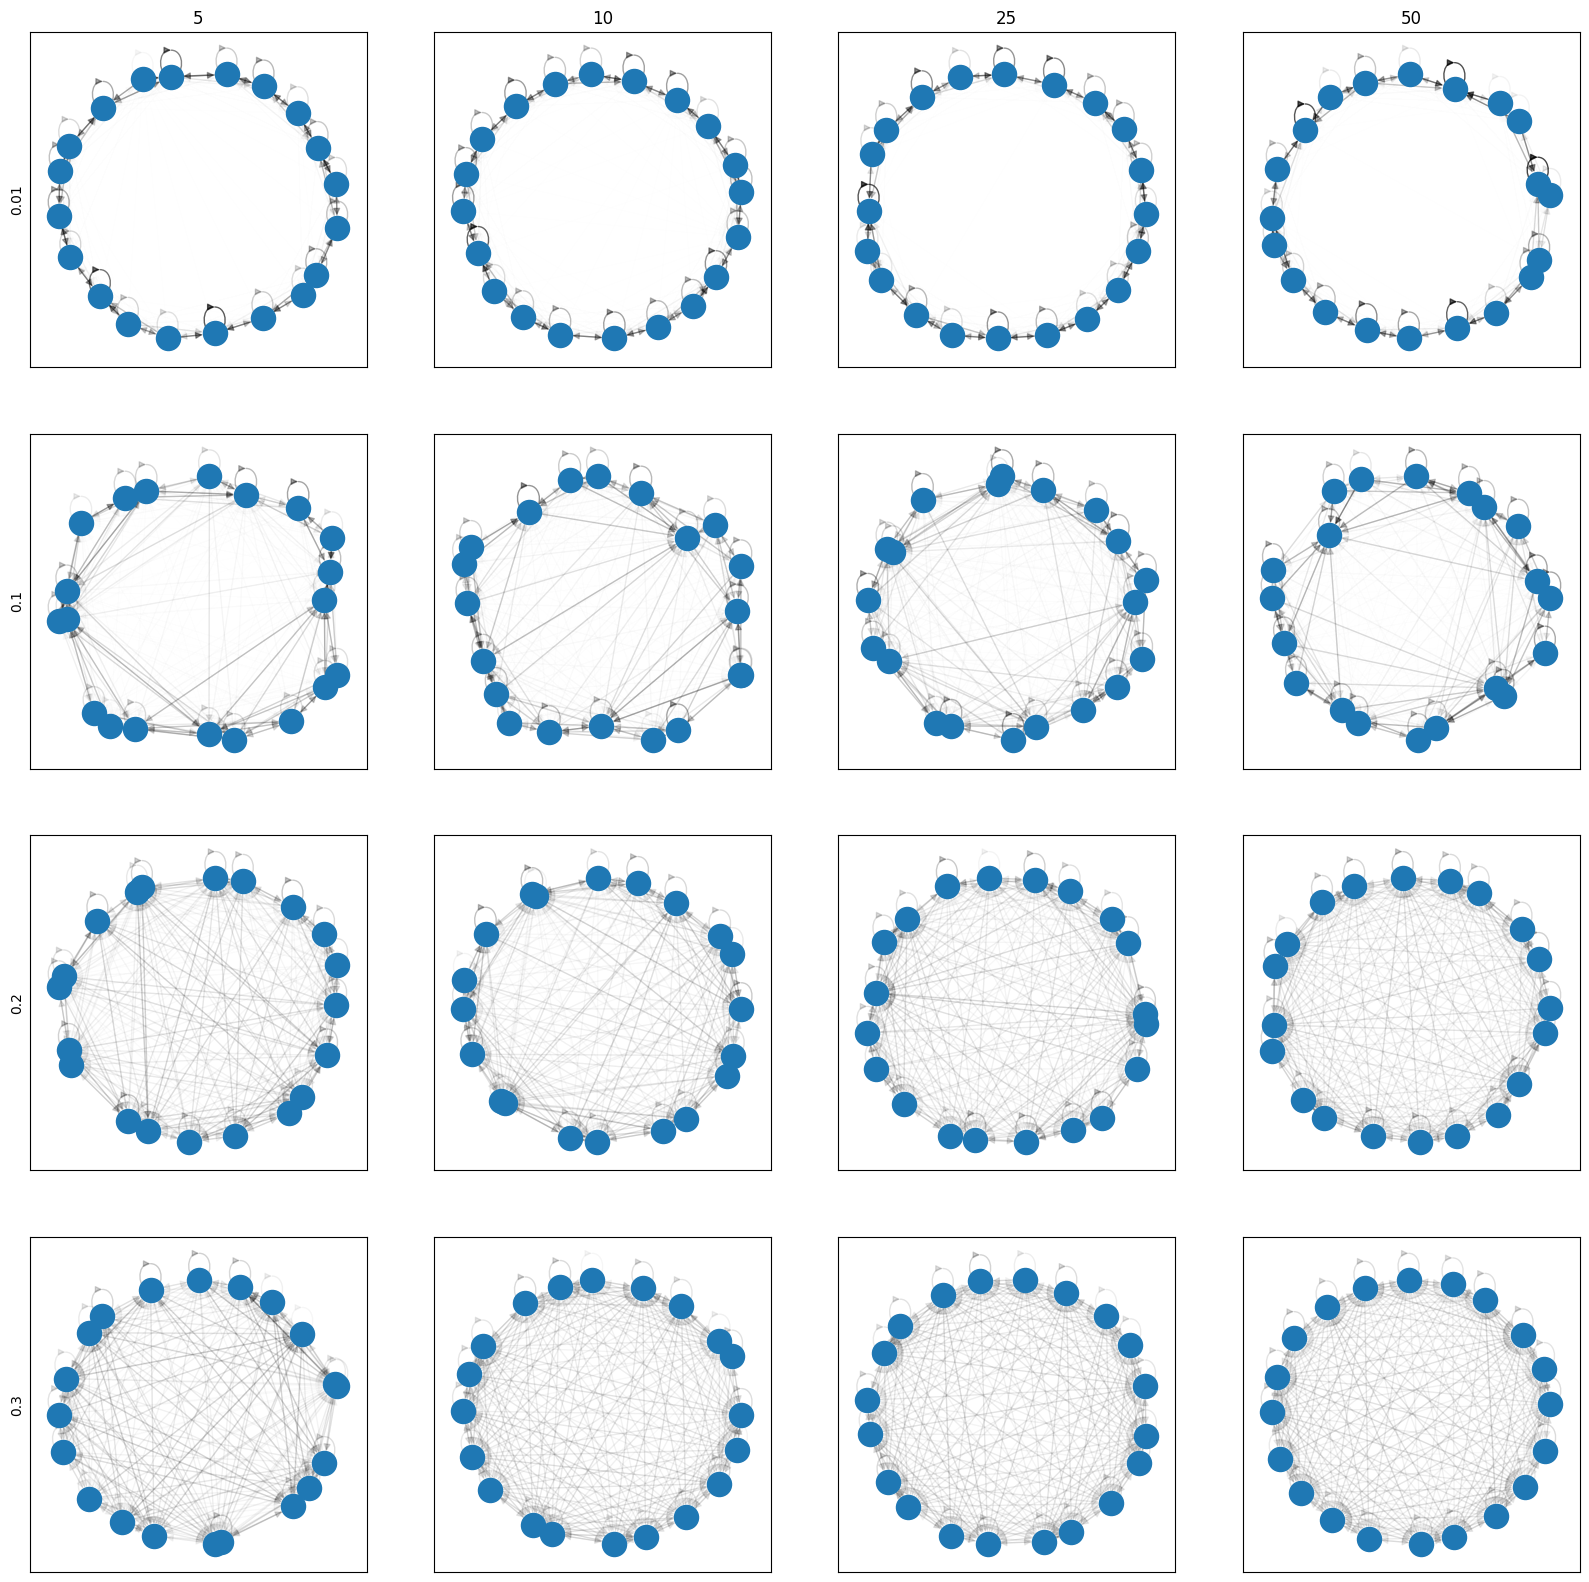

In [239]:
_, axes = plt.subplots(len(noise_values2), len(n_target_parameters2), figsize =(len(noise_values2)*5, len(n_target_parameters2)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values2), enumerate(n_target_parameters2)):
    projection_grid2[i][j].draw(ax=axes[i,j])
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


In [257]:
def my_threshold(M):
    median = np.median(M)
    #print(median)
    return .03
    return 2 * median # why hard when it could be easy

def markov_threshold(M, method=threshold_otsu):
    threshold = method(M)
    G = nx.from_numpy_array( M> threshold, create_using=nx.DiGraph)
    return G

Text(0.5, 0.98, 'number of inputs')

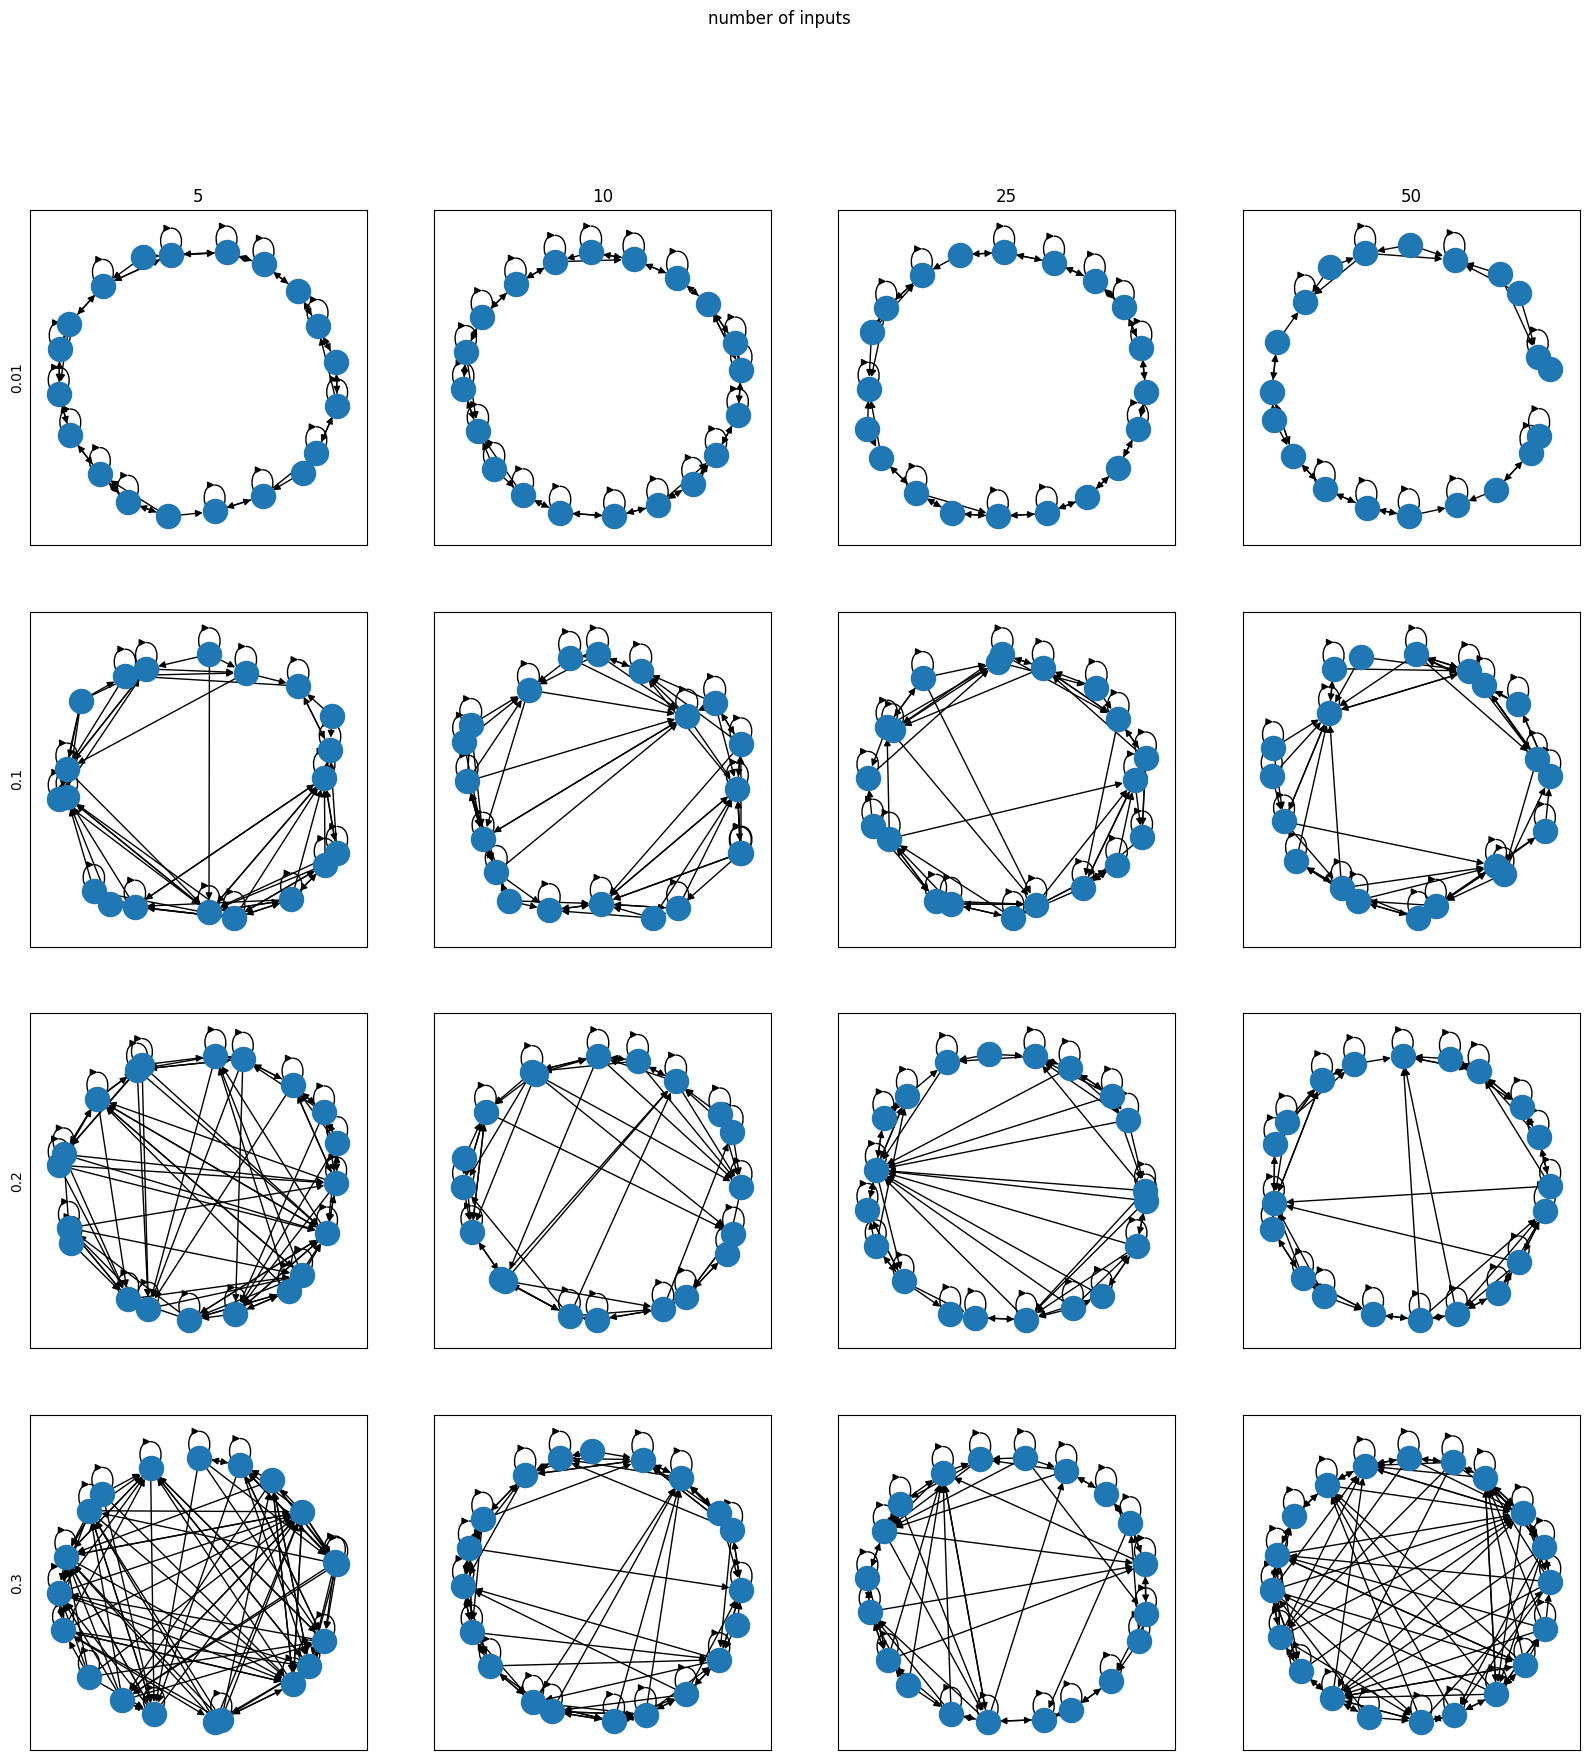

In [258]:
_, axes = plt.subplots(len(noise_values2), len(n_target_parameters2), figsize =(len(noise_values2)*5, len(n_target_parameters2)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values2), enumerate(n_target_parameters2)):
    markov, labels = projection_grid2[i][j].get()
    G = markov_threshold(markov.numpy(force=True))
    pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
    nx.draw(G, pos, ax=axes[i, j])
    axes[i, j].set_axis_on()
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    
plt.suptitle("number of inputs")



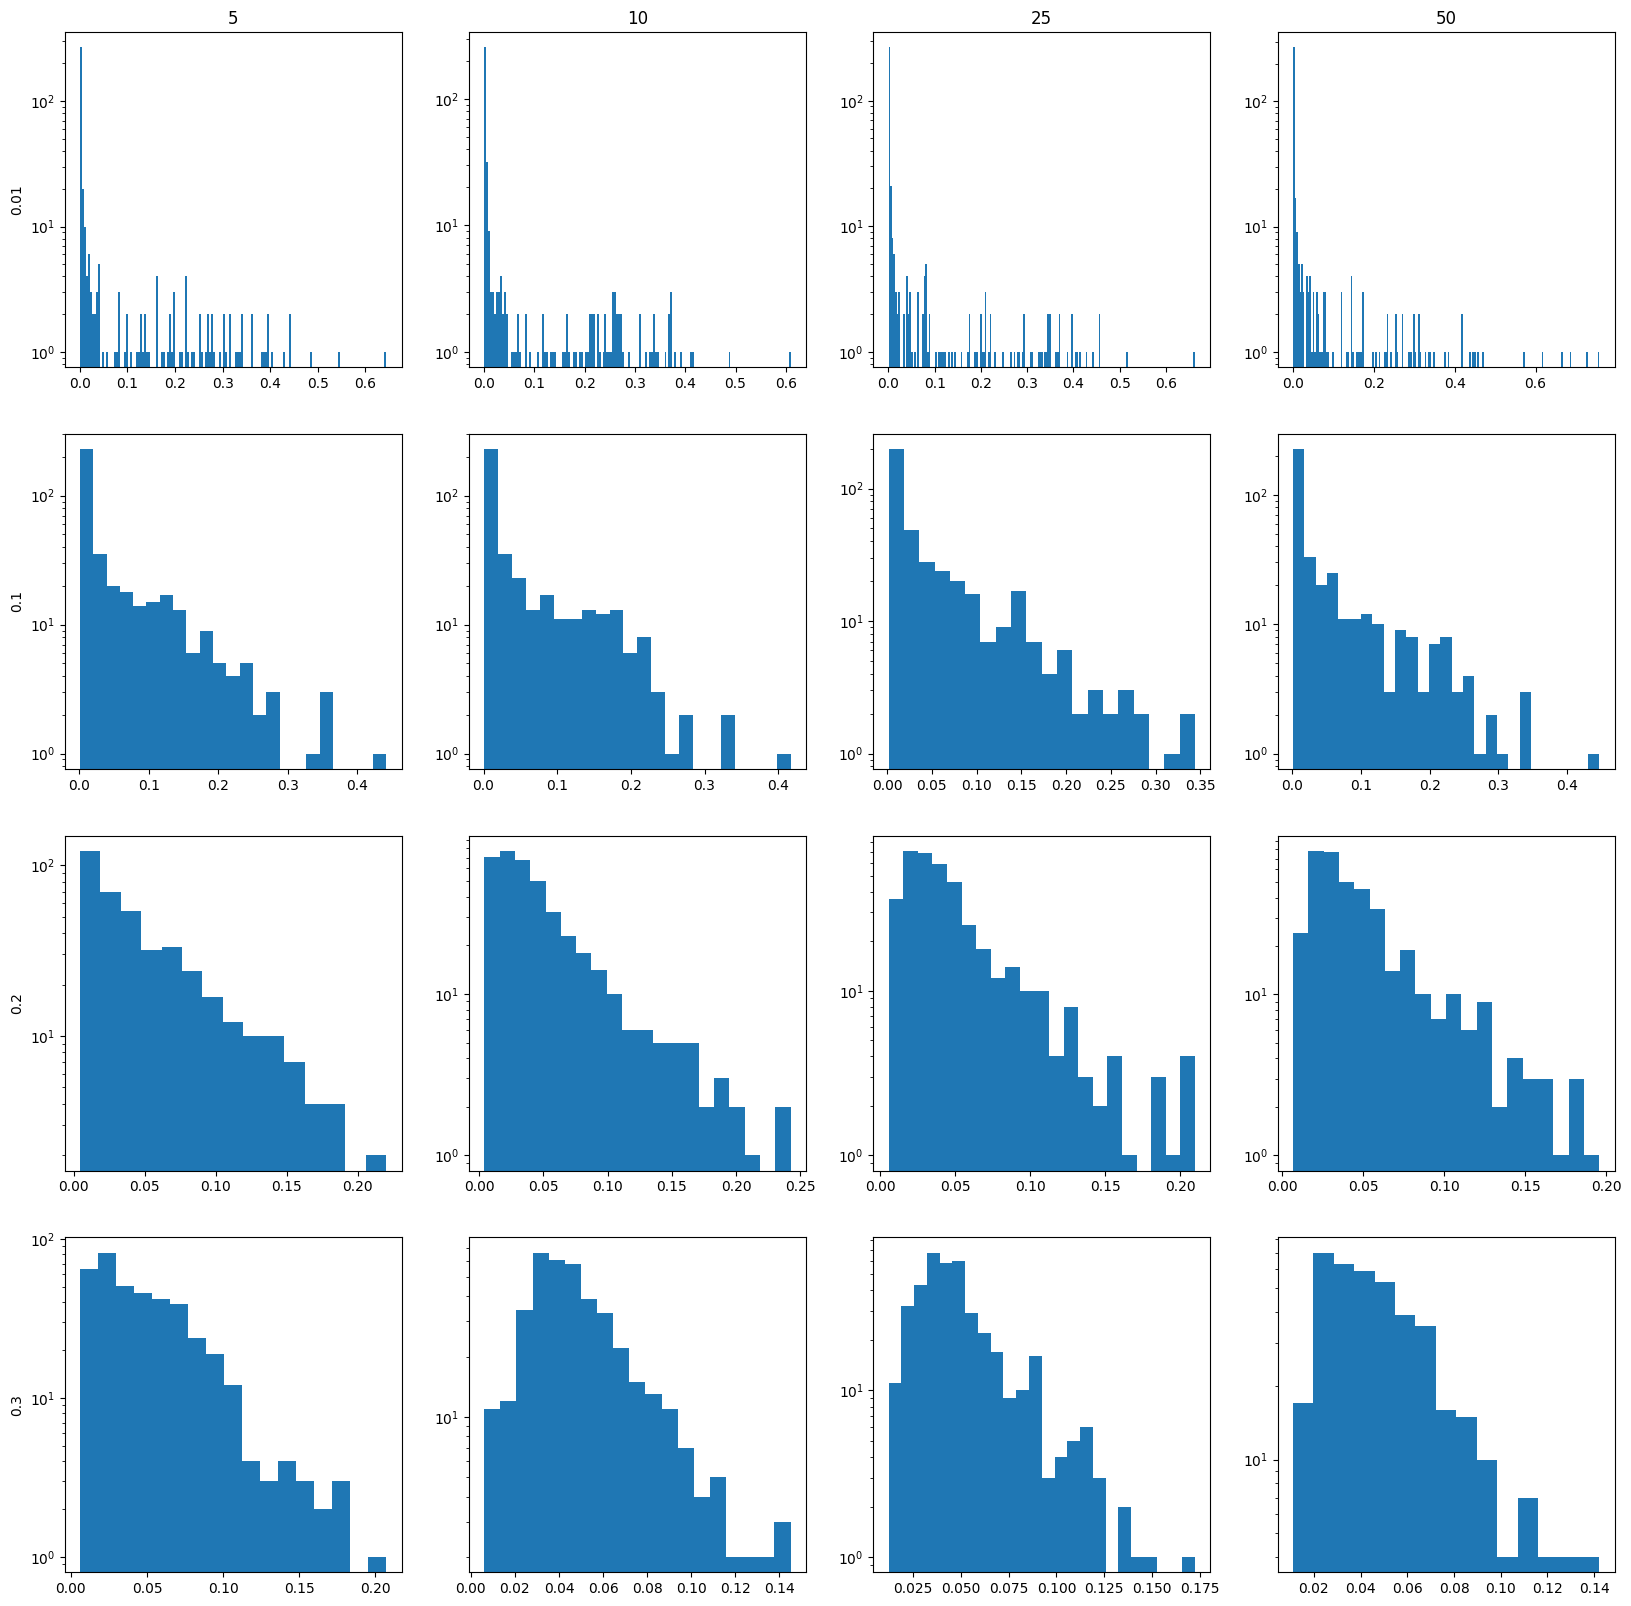

In [251]:
_, axes = plt.subplots(len(noise_values2), len(n_target_parameters2), figsize =(len(noise_values2)*5, len(n_target_parameters2)*5))

for (i, noise), (j, n_targets) in it.product(enumerate(noise_values2), enumerate(n_target_parameters2)):
    markov, labels = projection_grid2[i][j].get()
    G = markov_threshold(markov.numpy(force=True))
    pos = {i: l.numpy(force=True) for i, l in enumerate(labels)}
    plt.sca(axes[i, j])
    plt.hist(markov.numpy(force=True).flatten(), bins="auto")
    plt.yscale("log")
    if i==0:
        axes[i, j].set_title(f"{n_targets}")
    if j==0:
        axes[i, j].set_ylabel(f"{noise}")
    


## Same experiment but with matchings?

# 

In [190]:
projection_grid_matchings = grid_init(len(noise_values), len(n_target_parameters))
position_grid = grid_init(len(noise_values), len(n_target_parameters))

for (noise_index, noise), (n_target_index, n_target) in \
    it.product(enumerate(noise_values), enumerate(n_target_parameters)):
    target_graphs, original_positions, target_labels, target_matrices = get_data(target_size, n_target, data_type,
                                                                   er_p=noise)
    if projection_grid[noise_index][n_target_index] is not None:
        continue
    projection, parameter_values, losses = opt_loop_batched(
        target_matrices, 
        projection_size=projection_size,
        n_steps=5000,
        heat=5,
        lr=5e-3,
        weight_decay=1e-6,
        run_name=f"{data_type} - barycenter{projection_size} - {(run_number:=vars().get('run_number', 0)+1)}",
        labels=None
    )
    
    projection_grid[noise_index][n_target_index] = projection.cpu()
    position_grid[noise_index][n_target_index] =  np.asarray(list(nx.get_node_attributes(target_graphs[0], "pos").values()))

    %store projection_grid

projection.draw(original_positions)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/tristan/research/ot_markov_distances/ot_markov_distances/discounted_wl.py:85: UserWarning: regularized WL did not converge
  warnings.warn("regularized WL did not converge")


KeyboardInterrupt: 